In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import *
import tensorflow as tf
import cv2

sns.set_theme()

2024-04-08 15:31:01.831363: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-08 15:31:01.835751: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-08 15:31:01.938321: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-08 15:31:01.938371: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-08 15:31:01.939641: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [93]:
dataset_path = Path('./mnist_png')

files = dataset_path.rglob('*')
files

samples = []

for f in files:
    if not f.is_file():
        continue
        
    samples.append({
        'path': f,
        'label': int(f.parent.name),
        'split': f.parent.parent.name
    })
    
df = pd.DataFrame(samples)
df

,path,label,split
0,mnist_png/test/2/6773.png,2,test
1,mnist_png/test/2/995.png,2,test
2,mnist_png/test/2/1262.png,2,test
3,mnist_png/test/2/7518.png,2,test
4,mnist_png/test/2/2432.png,2,test
...,...,...,...
69995,mnist_png/train/1/44988.png,1,train
69996,mnist_png/train/1/14212.png,1,train
69997,mnist_png/train/1/10267.png,1,train
69998,mnist_png/train/1/46468.png,1,train


In [94]:
df.describe()

,label
count,70000.000000
mean,4.452429
std,2.890195
min,0.000000
25%,2.000000
50%,4.000000
75%,7.000000
max,9.000000


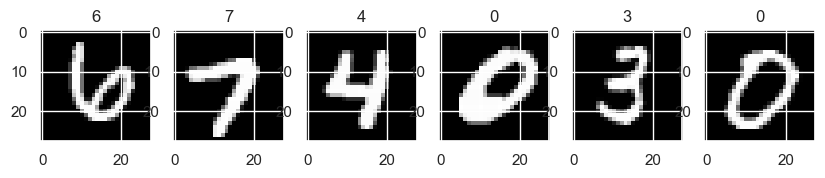

In [95]:
random_samples = df.sample(6)

fig, ax = plt.subplots(ncols=6, nrows=1, figsize=(10,4))

i = 0
for idx, row in random_samples.iterrows():
    img = cv2.imread(str(row.path))
    ax[i].imshow(img)
    ax[i].set_title(row.label)
    i = i+1
    
    

In [96]:
df_train = df[df.split == 'train'].sample(frac=1)
df_test = df[df.split == 'test'].sample(frac=1)

df_train.shape, df_test.shape


((60000, 3), (10000, 3))

In [19]:
# def my_gen():
#     print('INIT')
#     yield 1
#     print('A')
#     yield 2
#     print('B')
#     yield 3
#     print('C')
#     
#     
# def my_processing(numbers):
#     for x in numbers:
#         print('SQUARE ', x)
#         yield x**2
#     
# g = my_gen()
# g2 = my_processing(g)
# 
# for x in g2:
#     print('Get elelemnt ->', x)
    
    

INIT
SQUARE  1
Get elelemnt -> 1
A
SQUARE  2
Get elelemnt -> 4
B
SQUARE  3
Get elelemnt -> 9
C


In [56]:
# samples = [1,2,3,4]
# 
# ds = tf.data.Dataset.from_tensor_slices(samples)
# ds
# 
# for i in ds:
#     print(i)

tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)


In [137]:
def make_dataset(df_to_use, flatten=True):
    str_path = df_to_use.path.apply(str)

    ds_x = tf.data.Dataset.from_tensor_slices(str_path)
    ds_x = ds_x.map(lambda x: tf.io.read_file(x))
    ds_x = ds_x.map(lambda x: tf.image.decode_png(x))
    ds_x = ds_x.map(lambda x: x / 255)
    if flatten:
        ds_x = ds_x.map(lambda x: tf.reshape(x, (784,)))
    else:
        ds_x = ds_x.map(lambda x: tf.reshape(x, (28,28,1)))

    ds_y = tf.data.Dataset.from_tensor_slices(df_to_use.label)
    # ds_y = ds_y.map(lambda x: tf.one_hot(x, depth=10))

    ds = tf.data.Dataset.zip((ds_x, ds_y))
    
    ds = ds.batch(32, drop_remainder=True)
    
    return ds


train_ds = make_dataset(df_train)
test_ds = make_dataset(df_test)

# for sample in train_ds:

train_ds

<_BatchDataset element_spec=(TensorSpec(shape=(32, 784), dtype=tf.float32, name=None), TensorSpec(shape=(32,), dtype=tf.int64, name=None))>

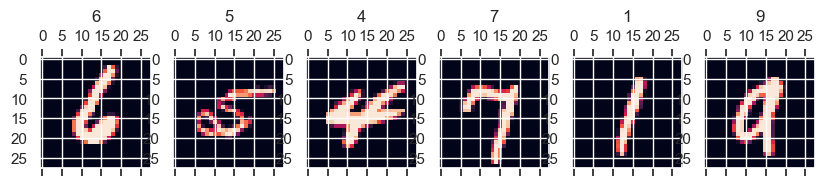

In [108]:
fig, ax = plt.subplots(ncols=6, nrows=1, figsize=(10,4))

i = 0
for sample in train_ds.take(6):
    img, label = sample
    ax[i].matshow(img)
    ax[i].set_title(label.numpy())
    i += 1


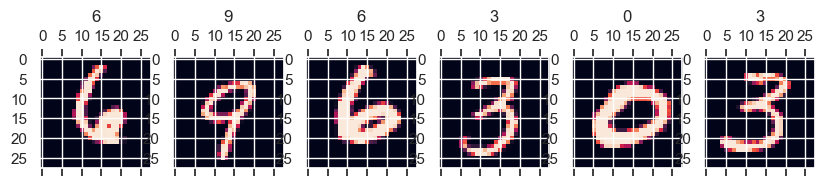

In [109]:
fig, ax = plt.subplots(ncols=6, nrows=1, figsize=(10,4))

i = 0
for sample in test_ds.take(6):
    img, label = sample
    ax[i].matshow(img)
    ax[i].set_title(label.numpy())
    i += 1



# Model

# FC

In [130]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, input_shape=(28*28,), activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(train_ds, validation_data=test_ds, epochs=2)

Epoch 1/2
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3520 - accuracy: 0.8978 - val_loss: 0.2173 - val_accuracy: 0.9365
Epoch 2/2
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1821 - accuracy: 0.9458 - val_loss: 0.1751 - val_accuracy: 0.9460


In [129]:
sample = next(iter(train_ds))
sample[1].shape


TensorShape([32])

# CNN

In [131]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax'),
])



In [142]:
model.save('./model.keras')

In [143]:
model_new = tf.keras.models.load_model('./model.keras')

ValueError: Input 0 of layer "conv2d" is incompatible with the layer: expected min_ndim=4, found ndim=2. Full shape received: (32, 784)

In [138]:

train_ds_2d = make_dataset(df_train, flatten=False)
test_ds_2d = make_dataset(df_test, flatten=False)
train_ds_2d


<_BatchDataset element_spec=(TensorSpec(shape=(32, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(32,), dtype=tf.int64, name=None))>

In [139]:


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(train_ds_2d, validation_data=test_ds_2d, epochs=2)




Epoch 1/2
1875/1875 [==============================] - 22s 11ms/step - loss: 0.1277 - accuracy: 0.9592 - val_loss: 0.0601 - val_accuracy: 0.9815
Epoch 2/2
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0426 - accuracy: 0.9869 - val_loss: 0.0415 - val_accuracy: 0.9865


In [140]:
model.evaluate(test_ds_2d)

312/312 [==============================] - 1s 4ms/step - loss: 0.0415 - accuracy: 0.9865


[0.04148859530687332, 0.9864783883094788]

In [141]:
predictions = model.predict(test_ds_2d)

312/312 [==============================] - 2s 5ms/step
